<a href="https://colab.research.google.com/github/satyammohan2202/Eye_Disease_Detection/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
folders = os.listdir('/content/drive/MyDrive/eye disease detection/split_dataset/train')

In [ ]:
folders

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
path = '/content/drive/MyDrive/eye disease detection/split_dataset/train/'
for i in folders:
  print(i, len(os.listdir(path+i)))

cataract 729
diabetic_retinopathy 768
glaucoma 704
normal 751


In [ ]:
import keras.utils as image
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_set = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=0.2,
    shear_range=0.2,
    zoom_range=0.2
)
valid_set = ImageDataGenerator(rescale=1/255)

In [ ]:
train_gen = train_set.flow_from_directory(path,
                                         target_size = (224, 224),
                                         batch_size = 32,
                                         class_mode = 'categorical')


val_path = '/content/drive/MyDrive/eye disease detection/split_dataset/val'
val_generator = valid_set.flow_from_directory(
    val_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 2952 images belonging to 4 classes.
Found 637 images belonging to 4 classes.


In [ ]:
for i, j in train_gen:
    print(i.shape, j.shape)
    break

(32, 224, 224, 3) (32, 4)


[0. 0. 0. 1.]


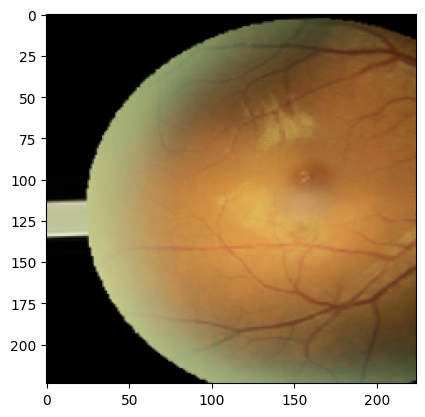

In [ ]:
plt.imshow(i[18])
print(j[18])

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
output = base_model.output
output = GlobalAveragePooling2D()(output)
output = Dropout(0.3)(output)
output = Dense(4, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(output)

In [ ]:
model = Model(inputs = base_model.input, outputs = output)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
hist = model.fit(train_gen, epochs = 35, validation_data = val_generator)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 1332s 13s/step - accuracy: 0.5252 - loss: 1.4542 - val_accuracy: 0.2606 - val_loss: 2.0336
Epoch 2/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 114s 744ms/step - accuracy: 0.6899 - loss: 0.8964 - val_accuracy: 0.2465 - val_loss: 14.5810
Epoch 3/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 731ms/step - accuracy: 0.7658 - loss: 0.7118 - val_accuracy: 0.2465 - val_loss: 17.8802
Epoch 4/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 777ms/step - accuracy: 0.7726 - loss: 0.6534 - val_accuracy: 0.2465 - val_loss: 4.1980
Epoch 5/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 71s 725ms/step - accuracy: 0.7781 - loss: 0.6166 - val_accuracy: 0.2465 - val_loss: 3.2251
Epoch 6/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 82s 727ms/step - accuracy: 0.8029 - loss: 0.5978 - val_accuracy: 0.2465 - val_loss: 2.6712
Epoch 7/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 72s 730ms/step - accuracy: 0.7845 - loss: 0.6706 - val_accuracy: 0.3846 - val_loss: 3.9083
Epoch 8/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 738ms/step - accuracy: 0.8401 - loss: 0.4823 - val_accuracy: 0.

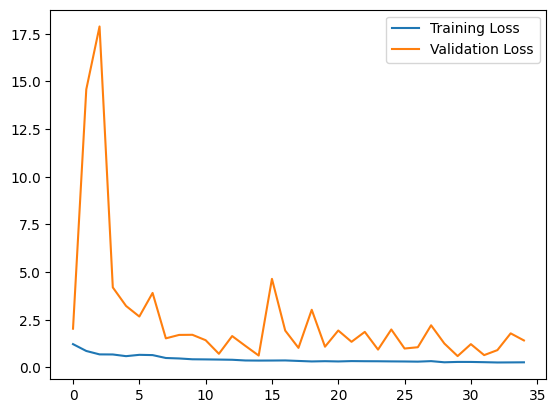

In [ ]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

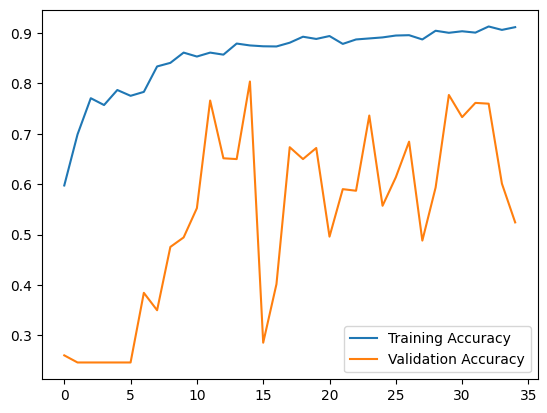

In [ ]:
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_set = ImageDataGenerator(rescale=1/255)
test_path = '/content/drive/MyDrive/eye disease detection/split_dataset/test'

test_gen = test_set.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 631 images belonging to 4 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 258s 14s/step - accuracy: 0.7672 - loss: 0.7322
Test Accuracy: 51.66%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes

report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys())
print(report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 509ms/step
                      precision    recall  f1-score   support

            cataract       0.38      0.99      0.55       155
diabetic_retinopathy       0.90      0.63      0.74       164
            glaucoma       0.62      0.39      0.48       151
              normal       0.53      0.06      0.11       161

            accuracy                           0.52       631
           macro avg       0.61      0.52      0.47       631
        weighted avg       0.61      0.52      0.47       631



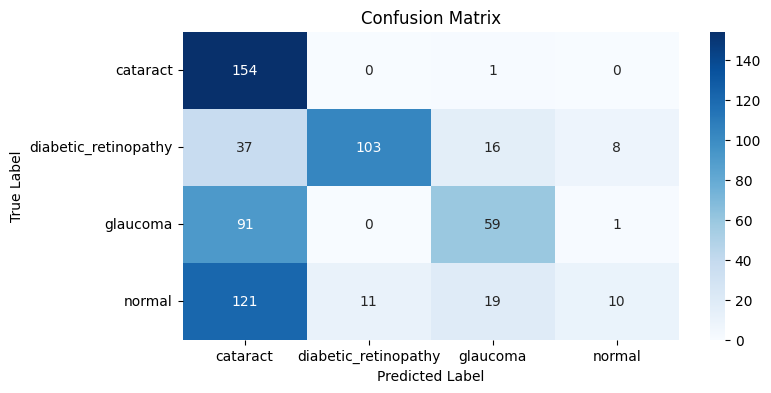

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
